# Feature Selection for log_diff_model (Multivariate Model)

In [42]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from bdi_predict.ml_logic.sequence_gen import WindowGenerator
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
bdi = pd.read_csv("../raw_data/data/BDI/log_diff_BDI_daily.csv")
bdi.head(2)

,Unnamed: 0,Date,Price,abs_price,log_price,log_diff
0,0,1995-01-03,1964.0,NaN,3.293141,NaN
1,1,1995-01-04,1961.0,-3.0,3.292478,-0.000664


In [62]:
bdi["Date"] = pd.to_datetime(bdi["Date"])
bdi.set_index("Date", inplace=True)
bdi= bdi[bdi.index != "1995-01-03"]
bdi.drop(columns="Unnamed: 0", inplace=True)
bdi.head(2)

,Price,abs_price,log_price,log_diff
Date,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664
1995-01-05,1967.0,6.0,3.293804,0.001327


In [63]:
df_imp = pd.read_csv("../raw_data/data/cleaned_important_features_data.csv")
df_imp.head(2)

,Year,"Natural_gas,_US","Shrimps,_Mexican",Barley,Soybean_oil,Platinum,Nickel,Aluminum,"Tobacco,_US_import_u.v.",Orange,"Sugar,_EU"
0,1995-02-01,1.58,13.70,85.77,663.0,413.97,8505.45,1916.15,2673.19,0.42,0.65
1,1995-03-01,1.54,14.04,90.83,652.0,416.89,7531.91,1805.07,2586.76,0.45,0.68


In [64]:
cgdp = pd.read_csv("../raw_data/data/CGDP/cleaned_daily_CGDP.csv")
cgdp["Date"] = pd.to_datetime(cgdp["Date"])
cgdp.set_index("Date", inplace=True)
cggp = cgdp[cgdp.index != "1995-01-03"]
#cgdp.drop(columns="Unnamed: 0", inplace=True)
cdgp.head(2)

,Price,cgdp,diff,cgdp_growth
Date,,,,
1995-01-04,1961.0,5.801770e+11,4.663836e+08,0.000804
1995-01-05,1967.0,5.806434e+11,4.663836e+08,0.000803


In [65]:
df = pd.merge(bdi, cgdp, on="Date", how="inner")
df.drop(columns="Price_y", inplace=True)


In [66]:
df.head(3)

,Price_x,abs_price,log_price,log_diff,cgdp,diff,cgdp_growth
Date,,,,,,,
1995-01-04,1961.0,-3.0,3.292478,-0.000664,5.801770e+11,4.663836e+08,0.000804
1995-01-05,1967.0,6.0,3.293804,0.001327,5.806434e+11,4.663836e+08,0.000803
1995-01-06,1983.0,16.0,3.297323,0.003518,5.811098e+11,4.663836e+08,0.000803


# Data Cleaning

## Holdout Method (manual, chronological)

In [68]:
input_length = len(df)

In [69]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [70]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [71]:
X_train = df_train[["Price_x","cgdp_growth"]]
y_train = df_train["log_diff"]

X_test  = df_test[["Price_x","cgdp_growth"]]
y_test = df_test["log_diff"]

In [95]:
#Feature Scaling

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.fit_transform(X_test)



In [98]:
generator = TimeseriesGenerator(X_train_scaled, y_train, length=20, batch_size=8, sampling_rate=1, stride=1)

In [99]:
len(generator)

680

In [100]:
generator_val = TimeseriesGenerator(X_test_scaled, y_test, length=20, batch_size=8, sampling_rate=1, stride=1)

In [101]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    #listy = [float(X[0][i]) for i in range(len(X[0]))]
    #print(listy)
    break

(8, 20, 2) (8,)
[[0.14519214 0.08983053]
 [0.14571379 0.0897544 ]
 [0.14710485 0.0896784 ]
 [0.14806121 0.27823653]
 [0.14988698 0.08937562]
 [0.15023474 0.08930022]
 [0.15188663 0.08922495]
 [0.15379934 0.0891498 ]
 [0.15440793 0.27665829]
 [0.15475569 0.08885038]
 [0.15475569 0.08877582]
 [0.15466875 0.08870138]
 [0.1537124  0.08862706]
 [0.15240828 0.27509756]
 [0.15136498 0.08833096]
 [0.1501478  0.08825722]
 [0.14823509 0.08818361]
 [0.14710485 0.08811011]
 [0.1465832  0.27355402]
 [0.14623544 0.08781726]] -0.0015435717560743


# The Model

In [102]:
# Learning Rate Scheduler: 

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [103]:
#Optimizers

rmsprop = RMSprop(learning_rate=lr_schedule) #or 0.001 for inital test
adam = Adam(learning_rate=lr_schedule)

In [115]:
#Early Stopping Criterion:

es = EarlyStopping(monitor="val_mae", patience=30, restore_best_weights=True)

In [116]:
#Initializing and compiling model:

def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(60, activation="tanh", input_shape=(10,2), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

In [117]:
#Model layers & params overview:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 60)                15120     
                                                                 
 dense_10 (Dense)            (None, 150)               9150      
                                                                 
 dense_11 (Dense)            (None, 1)                 151       
                                                                 
Total params: 24,421
Trainable params: 24,421
Non-trainable params: 0
_________________________________________________________________


# Training and Testing

In [127]:
#Instantiating model

model = init_model()

#TRAINING THE MODEL:

history = model.fit(
    generator, epochs=80, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/80
680/680 [==============================] - 5s 5ms/step - loss: 6.2142e-05 - mae: 0.0053 - val_loss: 1.1585e-04 - val_mae: 0.0083
Epoch 2/80
680/680 [==============================] - 3s 4ms/step - loss: 5.7508e-05 - mae: 0.0052 - val_loss: 9.4533e-05 - val_mae: 0.0074
Epoch 3/80
680/680 [==============================] - 3s 4ms/step - loss: 5.6423e-05 - mae: 0.0052 - val_loss: 8.2148e-05 - val_mae: 0.0068
Epoch 4/80
680/680 [==============================] - 3s 4ms/step - loss: 5.5357e-05 - mae: 0.0051 - val_loss: 8.1508e-05 - val_mae: 0.0068
Epoch 5/80
680/680 [==============================] - 3s 4ms/step - loss: 5.4841e-05 - mae: 0.0051 - val_loss: 7.8845e-05 - val_mae: 0.0066
Epoch 6/80
680/680 [==============================] - 3s 4ms/step - loss: 5.3938e-05 - mae: 0.0050 - val_loss: 8.1581e-05 - val_mae: 0.0068
Epoch 7/80
680/680 [==============================] - 3s 4ms/step - loss: 5.3653e-05 - mae: 0.0050 - val_loss: 8.0303e-05 - val_mae: 0.0067
Epoch 8/80
680/680 [

680/680 [==============================] - 3s 4ms/step - loss: 4.4503e-05 - mae: 0.0045 - val_loss: 7.1715e-05 - val_mae: 0.0063
Epoch 60/80
680/680 [==============================] - 3s 4ms/step - loss: 4.4542e-05 - mae: 0.0044 - val_loss: 7.8813e-05 - val_mae: 0.0067
Epoch 61/80
680/680 [==============================] - 3s 4ms/step - loss: 4.4093e-05 - mae: 0.0045 - val_loss: 6.4438e-05 - val_mae: 0.0061
Epoch 62/80
680/680 [==============================] - 3s 4ms/step - loss: 4.4074e-05 - mae: 0.0044 - val_loss: 6.4159e-05 - val_mae: 0.0061
Epoch 63/80
680/680 [==============================] - 3s 4ms/step - loss: 4.3699e-05 - mae: 0.0045 - val_loss: 6.3734e-05 - val_mae: 0.0060
Epoch 64/80
680/680 [==============================] - 3s 4ms/step - loss: 4.4113e-05 - mae: 0.0045 - val_loss: 6.8489e-05 - val_mae: 0.0062
Epoch 65/80
680/680 [==============================] - 3s 4ms/step - loss: 4.3987e-05 - mae: 0.0044 - val_loss: 9.4134e-05 - val_mae: 0.0073
Epoch 66/80
680/680 [====

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

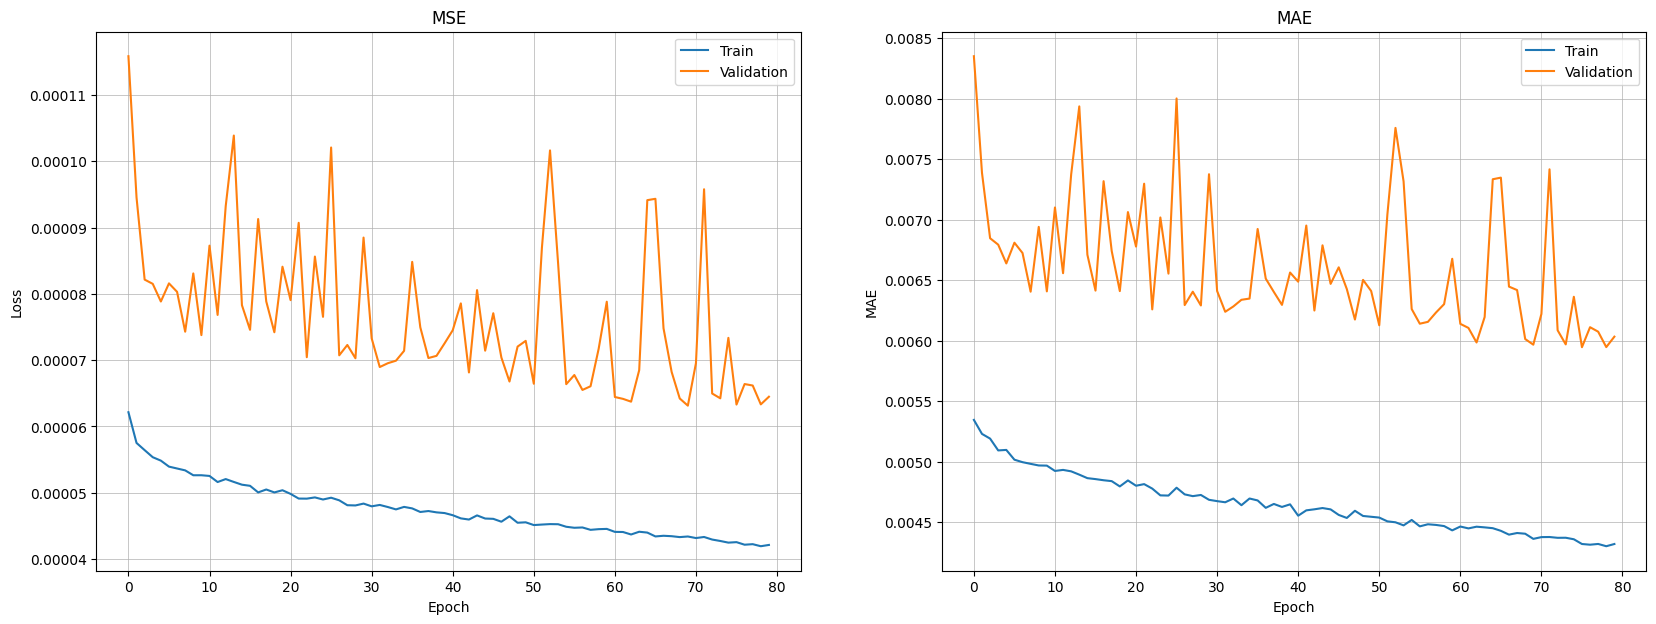

In [128]:
# Learning Curves:
plot_history(history)

In [129]:
#Baseline MAE
0.0048812746058099115

0.0048812746058099115

In [130]:
model.evaluate(generator_val)

168/168 [==============================] - 0s 978us/step - loss: 6.4481e-05 - mae: 0.0060


[6.448109343182296e-05, 0.006032424047589302]

# Learning Curves viz code:

In [82]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # Loss:MSE
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # Metrics:MAE
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax